In [3]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from numpy import percentile
from numpy.random import randn
import numpy as np
import os
from scipy.stats import norm, stats

In [13]:
def createStateDf(state, year):
    folder = "data/WICAgencies{}ytd/".format(year)
    
    stateDict = {
        "Date": pd.read_csv("data/WICAgencies{}ytd/Children_Participating.csv".format(year)).columns[1:-1]
    }
    
    for dataFile in os.listdir(folder):
        file = folder + dataFile
        stateDf = pd.read_csv(file).dropna()
        
        
        if len(stateDf.columns) == 14:
            stateData = stateDf[ stateDf[stateDf.columns[0]] == state ]
         
            stateData = np.array(stateDf[ stateDf[stateDf.columns[0]] == state ]).flatten()
            stateData = stateData[1:-1]
            
            stateDict[str(dataFile)[0:-4]] = stateData
        
    return pd.DataFrame(stateDict).drop(["Infants_Fully_Breastfed", "Infants_Fully_Formula-fed", 
                                         "Infants_Partially_Breastfed","Postpartum_Women_Participating", 
                                         "Pregnant_Women_Participating","Rebates_Received", 
                                         "Total_Breastfeeding_Women", "Women_Fully_Breastfeeding",
                                         "Women_Partially_Breastfeeding"], axis=1)


def trunc(df):
    for i, date in enumerate(df["Date"]):
        df.loc[i, "Date"] =  date[:-9]
    return df
        

def createFourYearDf(state):
    years = ["2013", "2014", "2015", "2016"]
    returnDf = pd.DataFrame()
    
    for year in years:
        returnDf = pd.concat([returnDf, trunc(createStateDf(state, year))], axis=0)
    
    return returnDf.reset_index(drop=True)

dfNewYork = createFourYearDf("New York")
dfNewYork.head()

,Date,Total_Infants,Total_Number_of_Participants,Average_Food_Cost_Per_Person,Food_Costs,Children_Participating,Total_Women
0,2012-10-01,117361.0,520563.0,55.5547,28919717.0,278854.0,124348.0
1,2012-11-01,117556.0,515920.0,58.55,30207094.0,275401.0,122963.0
2,2012-12-01,116186.0,506444.0,56.1518,28437767.0,270033.0,120225.0
3,2013-01-01,117897.0,514810.0,57.2702,29483293.0,274112.0,122801.0
4,2013-02-01,117153.0,513555.0,57.7211,29642985.0,274773.0,121629.0


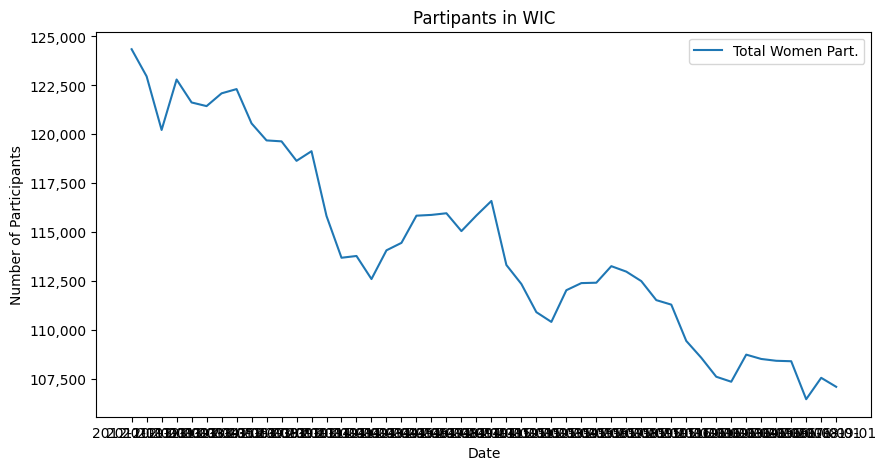

In [15]:
def number_format(x, pos):
    return '{:,.0f}'.format(x)

def graphParticipant(df):
    participantCols = ["Total_Infants", "Total_Number_of_Participants", "Children_Participating", "Total_Women"]

    plt.figure(figsize=(10, 5))
    plt.plot(df["Date"], df["Total_Women"], label="Total Women Part.")
    #plt.plot(df["Date"], df["Total_Infants"], label="Total Infant Part.")
    #plt.plot(df["Date"], df["Children_Participating"], label="Total Children Part.")

    plt.title("Partipants in WIC")
    plt.ylabel("Number of Participants") # set a meaningful ylabel
    plt.xlabel("Date") # set the xlabel to "Date"
    plt.legend()

    plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(number_format))

    plt.show()

graphParticipant(dfNewYork)

In [9]:
print(dfNewYork)

TypeError: 'str' object is not callable

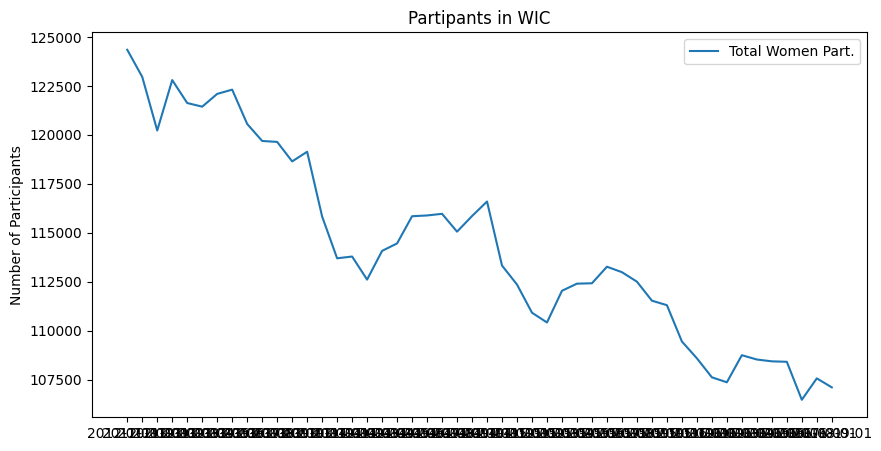

In [412]:
participantCols = ["Total_Infants", "Total_Number_of_Participants", "Children_Participating", "Total_Women"]

plt.figure(figsize=(10, 5))
plt.plot(dfNewYork["Date"], dfNewYork["Total_Women"], label="Total Women Part.")
    
plt.title("Partipants in WIC")
plt.ylabel("Number of Participants") # set a meaningful ylabel
plt.legend()
plt.xlabel("Date") # set the xlabel to "Date"

plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(number_format))

plt.show()

In [316]:
for i, date in enumerate(dfNewYork["Date"]):
    

2012-10-01 00:00:00
2012-11-01 00:00:00
2012-12-01 00:00:00
2013-01-01 00:00:00
2013-02-01 00:00:00
2013-03-01 00:00:00
2013-04-01 00:00:00
2013-05-01 00:00:00
2013-06-01 00:00:00
2013-07-01 00:00:00
2013-08-01 00:00:00
2013-09-01 00:00:00
2013-10-01 00:00:00
2013-11-01 00:00:00
2013-12-01 00:00:00
2014-01-01 00:00:00
2014-02-01 00:00:00
2014-03-01 00:00:00
2014-04-01 00:00:00
2014-05-01 00:00:00
2014-06-01 00:00:00
2014-07-01 00:00:00
2014-08-01 00:00:00
2014-09-01 00:00:00
2014-10-01 00:00:00
2014-11-01 00:00:00
2014-12-01 00:00:00
2015-01-01 00:00:00
2015-02-01 00:00:00
2015-03-01 00:00:00
2015-04-01 00:00:00
2015-05-01 00:00:00
2015-06-01 00:00:00
2015-07-01 00:00:00
2015-08-01 00:00:00
2015-09-01 00:00:00
2015-10-01 00:00:00
2015-11-01 00:00:00
2015-12-01 00:00:00
2016-01-01 00:00:00
2016-02-01 00:00:00
2016-03-01 00:00:00
2016-04-01 00:00:00
2016-05-01 00:00:00
2016-06-01 00:00:00
2016-07-01 00:00:00
2016-08-01 00:00:00
2016-09-01 00:00:00


In [319]:
df = pd.DataFrame({'A': [1, 2, 3], 'B': [4, 5, 6], 'C': [7, 8, 9]})
df.loc[0, 'B'] = 10

df

,A,B,C
0,1,10,7
1,2,5,8
2,3,6,9


AttributeError: 'SecondaryAxis' object has no attribute 'set_major_formatter'

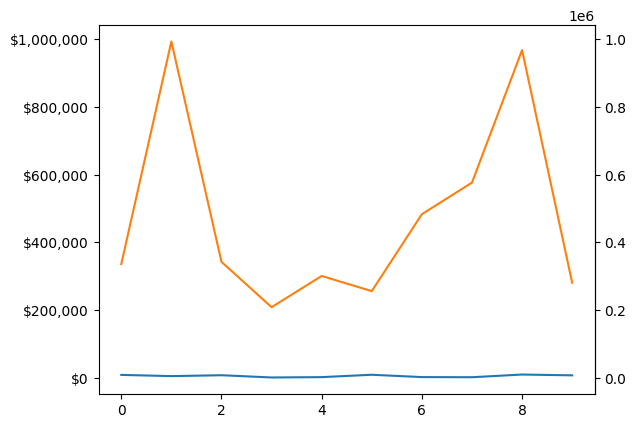

In [324]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

# generate some data for the plot
x = np.arange(10)
y1 = np.random.randint(1000, 10000, 10)
y2 = np.random.randint(100000, 1000000, 10)

# create the plot
fig, ax = plt.subplots()
line1, = ax.plot(x, y1, label='Line 1')
line2, = ax.plot(x, y2, label='Line 2')

# define the formatter functions
def dollar_format(x, pos):
    return '${:,.0f}'.format(x)

def percent_format(x, pos):
    return '{:.1f}%'.format(x)

# set the formatter for the y-axis of line 1
ax.yaxis.set_major_formatter(ticker.FuncFormatter(dollar_format))

# set the formatter for the y-axis of line 2
ax.secondary_yaxis('right').set_major_formatter(ticker.FuncFormatter(percent_format))

# set the formatter for the x-axis
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))

# add legend
ax.legend()

# display the plot
plt.show()